In [186]:
import numpy as np
import pandas as pd
seed = 32
import warnings
warnings.filterwarnings('ignore')
target =  'APP'

# Read ELHMA data 

In [2]:
def read_and_reformate_data(path):
    original_data = pd.read_csv(path)
     ### derive PLV_Totale and drop PLV of all stations
    original_data['PLV'] = original_data.iloc[:,4:24].sum(axis=1)    
    original_data.drop(original_data.iloc[:,4:23], axis=1, inplace=True)
    original_data.set_index('DATE', inplace=True)
    original_data.to_csv('hma_full_data.csv',index=False, sep=',')
    return original_data

In [3]:
elhma_data = read_and_reformate_data('full_dataset.csv')

# Read Kelibia climatic data

In [4]:
import datetime
def read_and_reformate_climatic_data(path):
    df = pd.read_excel(path, sheet_name='KELIBIA')
    df = df.drop(['NUM_STA','NOM_STA','Unnamed: 7'],axis=1)
    df.rename(columns={'DAT': 'DATE', 'Temp. Minimale °C' : 'Temp_min', 'Temp. Maximale °C':'Temp_max',
                        'Précipitation toat (mm)':'PLV', 'Evaporation Pch (mm)':'EVA'},inplace=True)
    df['DATE'] = pd.DatetimeIndex(df['DATE'])   
    df.set_index('DATE', inplace=True)
    return df

In [5]:
kelibia_climatic_data = read_and_reformate_climatic_data('KELIBIA.xlsx')

# Read Kelibia inflow data

In [6]:
# Load inflow target
def read_and_reformate_inflow(file):
    #convert string french months to numeric values
    df = pd.read_excel(file, sheet_name='Sheet1')
    df.rename(columns={'apport':'APP'},inplace=True)
    dates = df.pop('date')
    dates = dates.str.split(' ')
    months_names = ['Janvier','Février','Mars','Avril','Mai','Juin','Juillet','Aôut','Septembre','Octobre','Novembre','Décembre']
    months_values = ['01/01','02/01','03/01','04/01','05/01','06/01','07/01','08/01','09/01','10/01','11/01','12/01']
    data_date_format = []
    for date in dates:
        index = months_names.index(date[0])
        data_date_format.append(months_values[index]+'/'+date[1])
    df['date']= pd.DatetimeIndex(data_date_format)  
    df.set_index('date', inplace=True)
    return df

In [7]:
kelibia_inflow_data = read_and_reformate_inflow('apport.xlsx')

# Concatenate kelibia climatic data & inflow

In [8]:
from sklearn.model_selection import train_test_split
def concatunate_inflow(data_cleaned, inflow): 
    data = data_cleaned.copy()
    data['APP'] = np.nan
    for year in sorted(pd.unique(pd.DatetimeIndex(inflow.index).year)):
        for month in range(1,13):
            index_app = list(inflow[np.logical_and(year==pd.DatetimeIndex(inflow.index).year, 
                                                   month==pd.DatetimeIndex(inflow.index).month)].index)
            index_data = list(data[np.logical_and(year==pd.DatetimeIndex(data.index).year, 
                                               month==pd.DatetimeIndex(data.index).month)].index)
            if len(index_data)>0 and len(index_app)>0:
                data.loc[index_data, 'APP'] = inflow.loc[index_app, 'APP'].values[0]   
    data.dropna(axis=0,inplace=True)
    return data

kelibia_data = concatunate_inflow(kelibia_climatic_data, kelibia_inflow_data)

# Create statistsetical data for Kelibia data

In [9]:
def create_statistic_data(full_data):
    new_data = pd.DataFrame()
    #For each year
    full_data['DATE'] = full_data.index
    for year in pd.unique(pd.DatetimeIndex(full_data['DATE']).year):
        local_year_df = full_data[pd.DatetimeIndex(full_data['DATE']).year == year]
        #for each month
        for month in pd.unique(pd.DatetimeIndex(local_year_df['DATE']).month):
            #Get all samples for each month
            KELIBIA = full_data[(pd.DatetimeIndex(full_data['DATE']).month== month) & (pd.DatetimeIndex(full_data['DATE']).year ==year)]
            date = KELIBIA[['DATE']]
            # get min, max, mean, std, 25%, 50% and 75% for each column
            KELIBIA = KELIBIA.describe().drop(['count'],axis=0)
            #convert the DF from N*M dimonssion to 1*(M*N)  dimonssion
            KELIBIA = KELIBIA.unstack().to_frame().T
            KELIBIA.columns = ['_'.join(column) for column in KELIBIA.columns]
            #set the first date to meet as index 
            KELIBIA['DATE'] = date.iloc[0][0]
            KELIBIA = KELIBIA.set_index(KELIBIA['DATE'])

            new_data = new_data.append(KELIBIA)
    new_data = new_data.drop(['DATE','APP_std','APP_min','APP_25%','APP_50%','APP_75%','APP_max'],axis=1)
    new_data.rename(columns={'APP_mean':'APP'},inplace=True)

    return new_data  

In [10]:
kelibia_statistical_data = create_statistic_data(kelibia_data)

In [11]:
def get_percent_fo_missing_values(full_data):
    data = full_data
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (100*data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data[missing_data.Percent>0]

In [12]:
get_percent_fo_missing_values(kelibia_statistical_data)

,Total,Percent
Temp_min_std,12,4.979253
EVA_std,12,4.979253
Temp_max_std,12,4.979253
PLV_std,12,4.979253


In [13]:
get_percent_fo_missing_values(elhma_data)

,Total,Percent
Temp_min,3,0.102951


# Data preprocessing

In [14]:
def preprocessing(original_data):
    clean_data = original_data.copy()
    clean_data.drop_duplicates(keep='first', inplace=True)
    ### fill missing data 
    clean_data.interpolate(inplace=True)
    clean_data.fillna(method='bfill',inplace=True)    
    return clean_data

In [15]:
elhma_data = preprocessing(elhma_data)

In [16]:
kelibia_statistical_data = preprocessing(kelibia_statistical_data)

# Data exploration

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt 

def data_exploration(data, target):
    # checking skewness
    sf = data.skew()
    print('\nData Skewness:\n\n', sf)    # Checking correlation
    
    correlation = data.drop(['APP'],axis=1).corr('pearson')
    print('\nData Correlation:\n', correlation)
    fig = plt.figure()
    sns.heatmap(correlation)
    plt.show()
    target_corr = data.drop(['APP'],axis=1).corrwith(data[target])
    target_corr.plot.bar(figsize = (20, 10), title = "Correlation with the 'apport'", fontsize = 15,rot = 45, grid = True)
    plt.show()



Data Skewness:

 Temp_max    -0.069316
Temp_min     0.187688
Vent         0.534231
PLV          7.936422
EVA          0.748804
APP         20.295253
dtype: float64

Data Correlation:
           Temp_max  Temp_min      Vent       PLV       EVA
Temp_max  1.000000  0.880500  0.092122 -0.062674  0.834014
Temp_min  0.880500  1.000000 -0.001157 -0.134917  0.859242
Vent      0.092122 -0.001157  1.000000  0.087964  0.048082
PLV      -0.062674 -0.134917  0.087964  1.000000 -0.150792
EVA       0.834014  0.859242  0.048082 -0.150792  1.000000


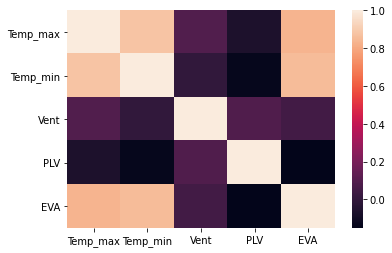

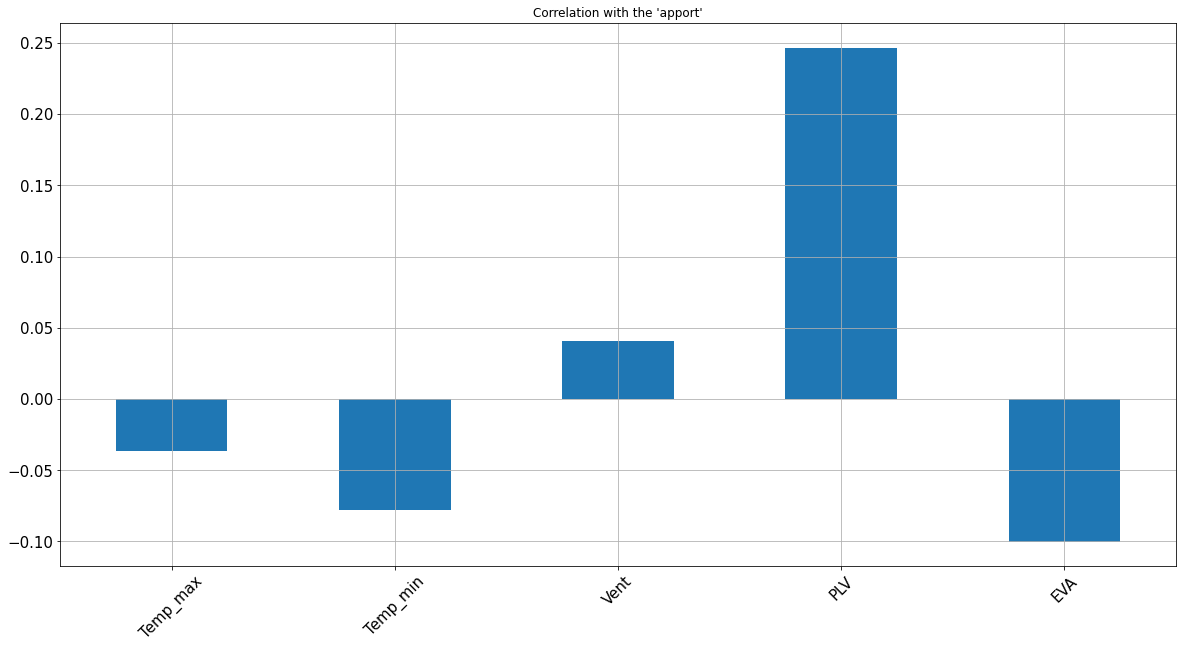

In [18]:
data_exploration(elhma_data, target)


Data Skewness:

 Temp_min_mean    0.288420
Temp_min_std     0.125430
Temp_min_min     0.368853
Temp_min_25%     0.337487
Temp_min_50%     0.260674
Temp_min_75%     0.221952
Temp_min_max     0.142347
Temp_max_mean    0.298462
Temp_max_std     0.222977
Temp_max_min     0.319463
Temp_max_25%     0.354520
Temp_max_50%     0.309993
Temp_max_75%     0.261673
Temp_max_max     0.202006
PLV_mean         2.418783
PLV_std          3.618983
PLV_min          9.896182
PLV_25%          5.245669
PLV_50%          1.979418
PLV_75%          1.800180
PLV_max          3.266297
EVA_mean         0.908991
EVA_std          1.362224
EVA_min          1.290157
EVA_25%          1.171944
EVA_50%          1.083458
EVA_75%          0.752754
EVA_max          0.580247
APP              5.052624
dtype: float64

Data Correlation:
                Temp_min_mean  Temp_min_std  Temp_min_min  Temp_min_25%  \
Temp_min_mean       1.000000     -0.158508      0.966875      0.990531   
Temp_min_std       -0.158508      1.000000   

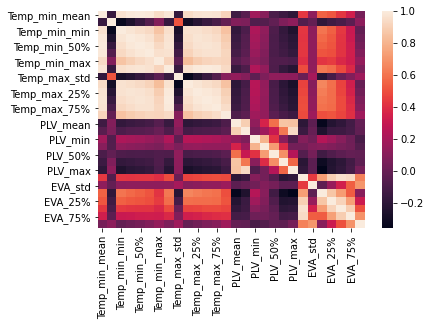

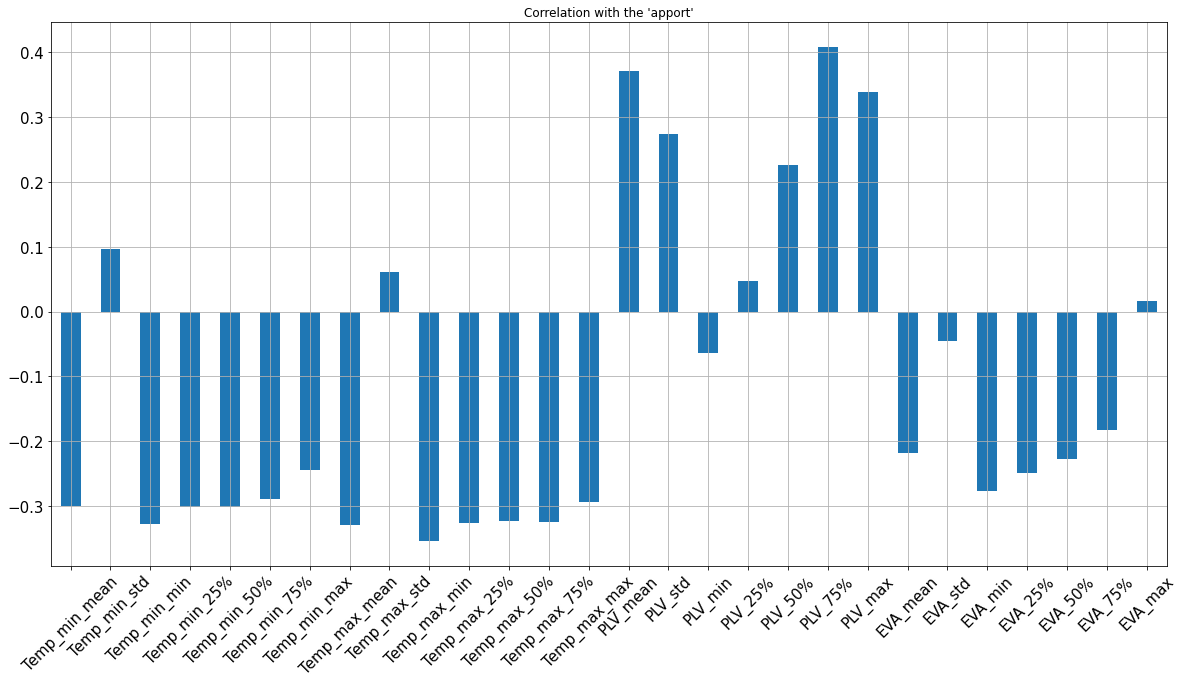

In [19]:
data_exploration(kelibia_statistical_data, target)

# I. We will test the correlation with the target, if there is less then 50% of other attribut that have corr less the then a Threshold that's mean that we have a bad data quality that cannot be exploitable

In [20]:
def test_corr_with_target_validity(data, target, percent_of_attributs, Threshold):
    number_of_attributs= int(round(percent_of_attributs*len(data.columns)))
    number_of_corrolated_attributs = 0 
    target_corr = data.drop(['APP'],axis=1).corrwith(data[target])
    for elem in target_corr:
         if abs(elem) >= Threshold:
                number_of_corrolated_attributs+=1
    if number_of_corrolated_attributs>=number_of_attributs:
        print('Correlation Verification satisfied: there is {0} attribut(s) that have a correlation value grater then {1}'.format(number_of_corrolated_attributs, Threshold))
        return True

    print('Correlation validation is not satisfied, there is only {0} attribut(s) that have a correlation with the target grater then {1}'.format(number_of_corrolated_attributs, Threshold))
    return False

In [21]:
percent_of_attributs = 0.5
Threshold = 0.2

In [22]:
result = test_corr_with_target_validity(kelibia_statistical_data, target, percent_of_attributs, Threshold)

Correlation Verification satisfied: there is 21 attribut(s) that have a correlation value grater then 0.2


In [23]:
result = test_corr_with_target_validity(elhma_data, target, percent_of_attributs, Threshold)

Correlation validation is not satisfied, there is only 1 attribut(s) that have a correlation with the target grater then 0.2


# II. The second test of correlation is between all other attributs ( different to target). To have a good predicion, attributs must be not correlated with each other

In [24]:
def test_corr_between_other_attributs(data, target, percent_of_attributs, Threshold):
    
    data_correlation_df = data.drop(['APP'],axis=1).corr('pearson')
    total_number_of_cells= len(data_correlation_df.columns)**2
    number_of_cells= int(round(percent_of_attributs*len(data_correlation_df.columns)*len(data_correlation_df.columns)))
    number_of_corrolated_cells = 0 
    for  col in data_correlation_df.columns:
        for row_number in  range(len(data_correlation_df)):
            if data_correlation_df.iloc[row_number][col]> Threshold:
                number_of_corrolated_cells+=1
            
    if number_of_corrolated_cells<=number_of_cells:
        print('Correlation Verification satisfied: there is {0} cell(s) from {1} cells that have a correlation value lower then {2}'.format(number_of_corrolated_cells, total_number_of_cells, Threshold))
        return True

    print('Correlation validation is not satisfied, there is {0} cell(s) from {1} cells that have a correlation between each other grater then {2}'.format(number_of_corrolated_cells, total_number_of_cells, Threshold))
    return False

In [25]:
percent_of_attributs = 0.5
Threshold = 0.2

In [26]:
result = test_corr_between_other_attributs(kelibia_statistical_data, target, percent_of_attributs, Threshold)

Correlation Verification satisfied: there is 366 cell(s) from 784 cells that have a correlation value lower then 0.2


In [27]:
result = test_corr_between_other_attributs(elhma_data, target, percent_of_attributs, Threshold)

Correlation Verification satisfied: there is 11 cell(s) from 25 cells that have a correlation value lower then 0.2


# III. Now we go to anomalies detection, If the percent of anomalies is >=50% that's mean that our data is not exploitable

In [47]:
saisons = ['Automne', 'Hiver', 'Printemps', 'Eté']

def create_seasonal_data(full_data):
    data = [pd.DataFrame() for i in range(4)]     
    month = pd.DatetimeIndex(full_data.index).month
    #Autumn
    data[0] = full_data[np.logical_or(month==9,np.logical_or(month==10,month==11))] 
    #Winter
    data[1] = full_data[np.logical_or(month==12,np.logical_or(month==1, month==2))]   
    #Spring
    data[2] = full_data[np.logical_or(month==3,np.logical_or(month==4, month==5))]
    #Summer
    data[3] = full_data[np.logical_or(month==6,np.logical_or(month==7, month==8))] 
    return data

In [64]:
Kelibia_seasonal_data = create_seasonal_data(kelibia_statistical_data)

In [65]:
ELHMA_seasonal_data = create_seasonal_data(elhma_data)

In [50]:
from sklearn.model_selection import train_test_split
def split_data_into_train_and_test_sets(seasonal_data):
    train_seasonal_data = []
    for index , subset_elem in enumerate(seasonal_data):
        data_train, data_test = train_test_split(subset_elem, test_size=0.15, random_state=seed, shuffle=True)
        train_seasonal_data.append(data_train)
    return train_seasonal_data

In [66]:
Kelibia_train_seasonal_data = split_data_into_train_and_test_sets(Kelibia_seasonal_data)

In [67]:
ELHMA_train_seasonal_data = split_data_into_train_and_test_sets(ELHMA_seasonal_data)

In [53]:
def Principal_Components_Analysis(data_train):
    # find the number of components (features) to keep                          
    mean_vec = np.mean(data_train, axis=0)
    cov_mat = np.cov(data_train.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs.sort(key = lambda x: x[0], reverse= True)
    tot = sum(eig_vals)
    var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
    cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
    plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.show();

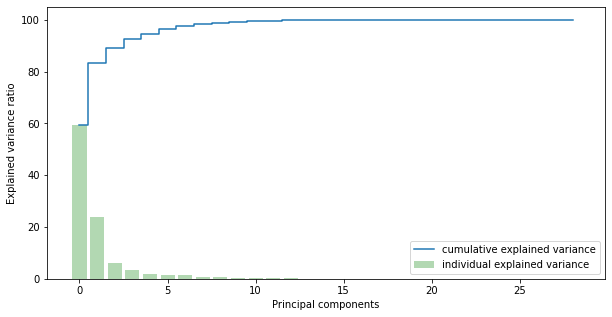

In [54]:
Principal_Components_Analysis(Kelibia_train_seasonal_data[3])

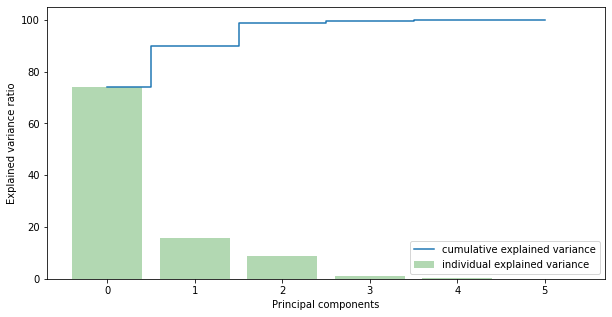

In [55]:
Principal_Components_Analysis(ELHMA_train_seasonal_data[3])

In [56]:
def build_detecor(data, detector):
    #scaling
    scaler = StandardScaler().fit(data)
    data = pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)
    # PCA dimensionality reduction
    pca = PCA(n_components=3).fit(data) # !!! scaled training data
    data = pd.DataFrame(pca.transform(data), index=data.index, columns = ['PC1', 'PC2', 'PC3'])
    # anomaly detector
    detector = detector.fit(data)
    return scaler, pca, detector

In [161]:
def anomaly_detection(data, scaler, pca, detector, is_fit):
    transformed_data = pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)
    transformed_data = pd.DataFrame(pca.transform(transformed_data), index=transformed_data.index, columns = ['PC1', 'PC2', 'PC3'])
    #pred  = detector.predict(transformed_data)
    if is_fit== True:
        detector  = detector.fit(transformed_data)
        if detector.__class__.__name__ =='LocalOutlierFactor':
            pred  = detector.fit_predict(transformed_data)
        else:
            pred  = detector.predict(transformed_data)
    else:
        pred  = detector.fit_predict(transformed_data)
    
    data['anomaly'] = pred
    outliers = list(data[data['anomaly']==-1].index)    
    return transformed_data, data, outliers

In [58]:
def filter_outlier(X, outliers):
    X.loc[outliers, :] = np.nan
    X.interpolate(inplace=True)
    X.fillna(method='bfill',inplace=True)    
    return X

In [211]:
def plot_and_test_errors_of_sesonal_anomalies(train_seasonal_data, seasonal_data, model, percent_of_tolerated_errors,  is_fit = True):
    fig = plt.figure(figsize=(20,10))
    outliers = [None] * 4

    for index , subset_elem in enumerate(train_seasonal_data):

        ax = fig.add_subplot(2, 2, index+1, projection='3d')

        # build anomay detector
        scaler, pca, detector = build_detecor(subset_elem, model)

        # anomaly detection
        transformed_data, seasonal_data[index], outliers[index] = anomaly_detection(seasonal_data[index], scaler, pca, detector, is_fit)

        #Plot the compressed data points
        ax.scatter(transformed_data.loc[:,'PC1'], transformed_data.loc[:,'PC2'], zs=transformed_data.loc[:,'PC3'], s=4, lw=1, label="inliers",c="green")
        ax.scatter(transformed_data.loc[outliers[index],'PC1'],transformed_data.loc[outliers[index],'PC2'],transformed_data.loc[outliers[index],'PC3'],lw=2, s=60, marker="x", c="red", label="outliers")
        ax.title.set_text(saisons[index])
        ax.legend()    

        # filter anomalies
        seasonal_data[index] = filter_outlier(seasonal_data[index], outliers[index])    

    plt.show()
    count_outliers = 0
    count_seasonal_data = 0
    for listElem in outliers:
        count_outliers += len(listElem) 
    for listElem in seasonal_data:
        count_seasonal_data += len(listElem) 
        
    print_results(count_outliers, count_seasonal_data, percent_of_tolerated_errors,detector)
    
    return count_outliers, count_seasonal_data

In [242]:
def print_results(count_outliers, count_seasonal_data, percent_of_tolerated_errors, detector):
    percent_of_anomalies = count_outliers/count_seasonal_data
    
    if percent_of_anomalies > percent_of_tolerated_errors:
        print("""Errors verification: this data cannot be used for modeling. Based on {0} algorithm result,
                 we have  {1}% of anomalies which is heigher then {2}% tolerated anoamlies
                  """.format(detector.__class__.__name__,round(percent_of_anomalies,3), percent_of_tolerated_errors))
    else:
         print("""Errors verification: this data can be used for modeling. Based on {0} algorithm result,
                 we have  {1}% of anomalies which is lower then {2}% tolerated anoamlies
                  """.format(detector.__class__.__name__,round(percent_of_anomalies*100,3), percent_of_tolerated_errors*100))

In [243]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn import svm
from sklearn.covariance import EllipticEnvelope

from mpl_toolkits.mplot3d import Axes3D

## Use fit_predict
DB = DBSCAN(eps =0.6, metric='euclidean', min_samples=3, n_jobs=-1)
LOF = LocalOutlierFactor(n_neighbors=5, contamination=0.01)
## Use predict
IForest=IsolationForest(n_estimators=100,max_samples='auto',
                        contamination=0.01,max_features=1.0,
                        bootstrap=True, n_jobs=-1, random_state=42, verbose=0)
EE = EllipticEnvelope()
percent_of_tolerated_errors = 0.5

In [244]:
### KELIBIA test

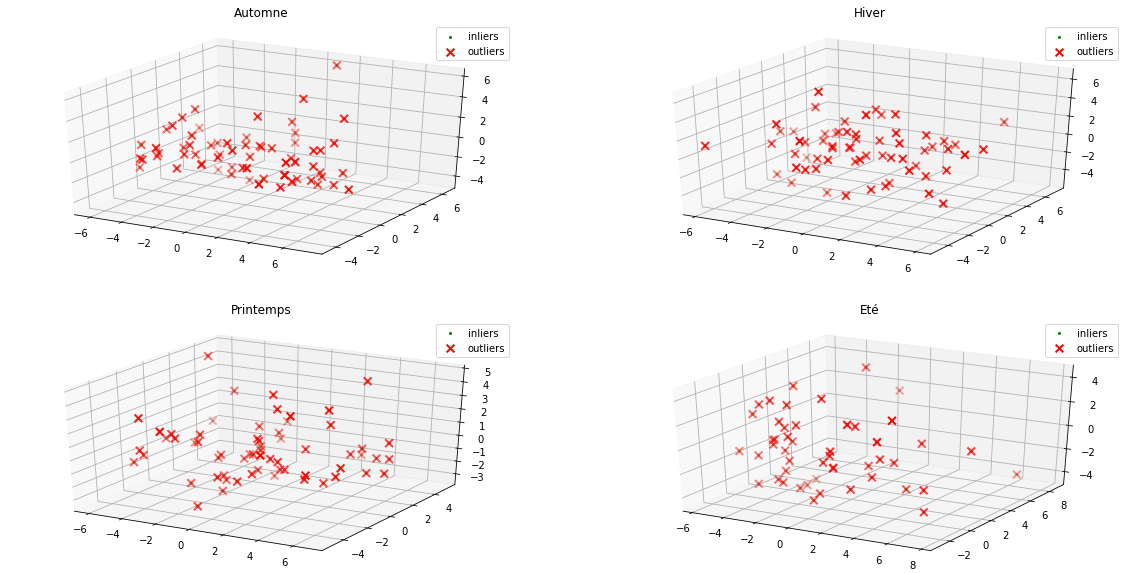

Errors verification: this data cannot be used for modeling. Based on DBSCAN algorithm result,
                 we have  1.0% of anomalies which is heigher then 0.5% tolerated anoamlies
                  


(241, 241)

In [245]:
Kelibia_seasonal_data = create_seasonal_data(kelibia_statistical_data)
Kelibia_train_seasonal_data = split_data_into_train_and_test_sets(Kelibia_seasonal_data)
plot_and_test_errors_of_sesonal_anomalies(Kelibia_train_seasonal_data, Kelibia_seasonal_data, DB, percent_of_tolerated_errors, is_fit = False)

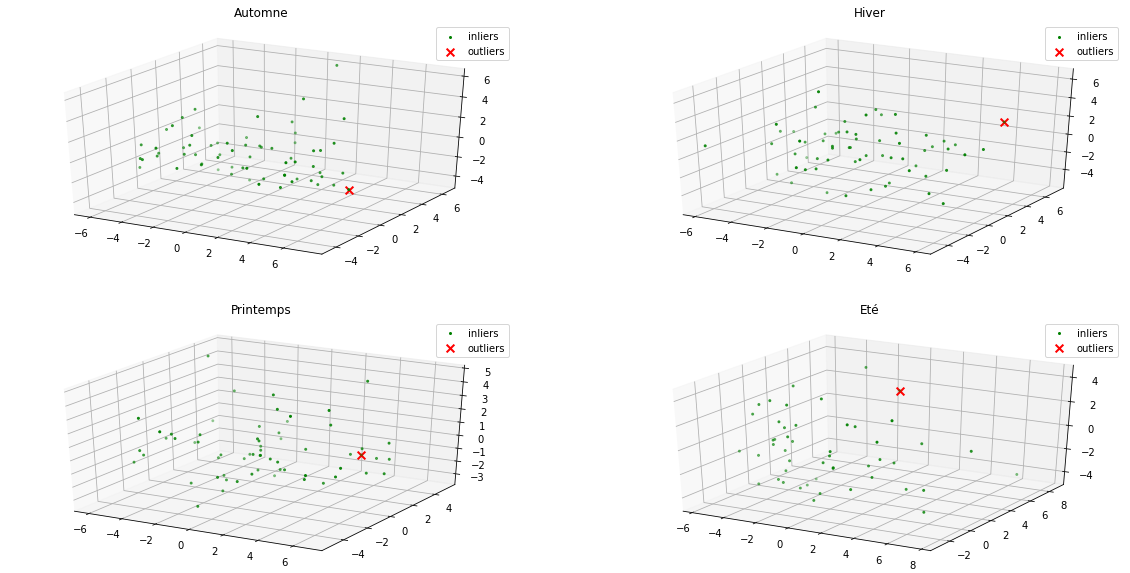

Errors verification: this data can be used for modeling. Based on LocalOutlierFactor algorithm result,
                 we have  1.66% of anomalies which is lower then 50.0% tolerated anoamlies
                  


(4, 241)

In [246]:
Kelibia_seasonal_data = create_seasonal_data(kelibia_statistical_data)
Kelibia_train_seasonal_data = split_data_into_train_and_test_sets(Kelibia_seasonal_data)
plot_and_test_errors_of_sesonal_anomalies(Kelibia_train_seasonal_data, Kelibia_seasonal_data, LOF, percent_of_tolerated_errors, is_fit = False)

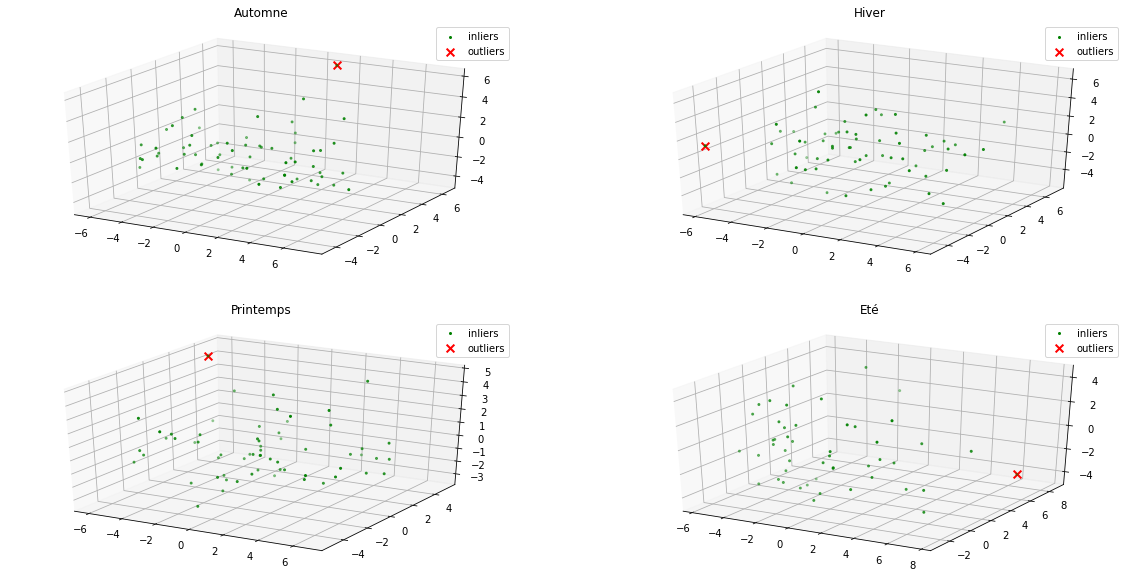

Errors verification: this data can be used for modeling. Based on IsolationForest algorithm result,
                 we have  1.66% of anomalies which is lower then 50.0% tolerated anoamlies
                  


(4, 241)

In [247]:
Kelibia_seasonal_data = create_seasonal_data(kelibia_statistical_data)
Kelibia_train_seasonal_data = split_data_into_train_and_test_sets(Kelibia_seasonal_data)
plot_and_test_errors_of_sesonal_anomalies(Kelibia_train_seasonal_data, Kelibia_seasonal_data, IForest, percent_of_tolerated_errors, is_fit = True)

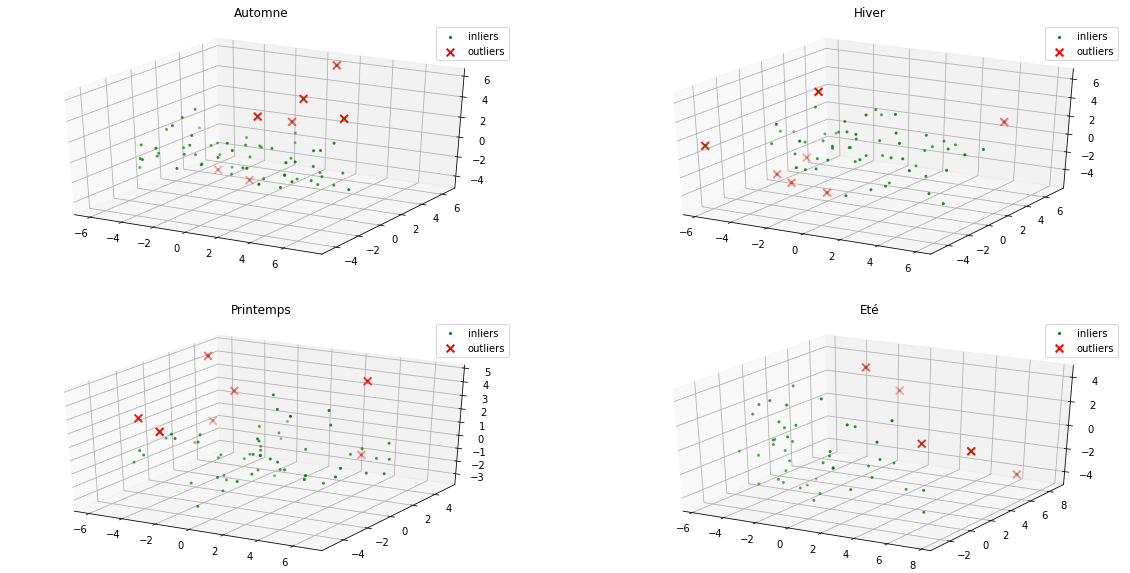

Errors verification: this data can be used for modeling. Based on EllipticEnvelope algorithm result,
                 we have  10.788% of anomalies which is lower then 50.0% tolerated anoamlies
                  


(26, 241)

In [254]:
Kelibia_seasonal_data = create_seasonal_data(kelibia_statistical_data)
Kelibia_train_seasonal_data = split_data_into_train_and_test_sets(Kelibia_seasonal_data)
plot_and_test_errors_of_sesonal_anomalies(Kelibia_train_seasonal_data, Kelibia_seasonal_data, EE, percent_of_tolerated_errors, is_fit = True)

In [249]:
### ELHMA TEST

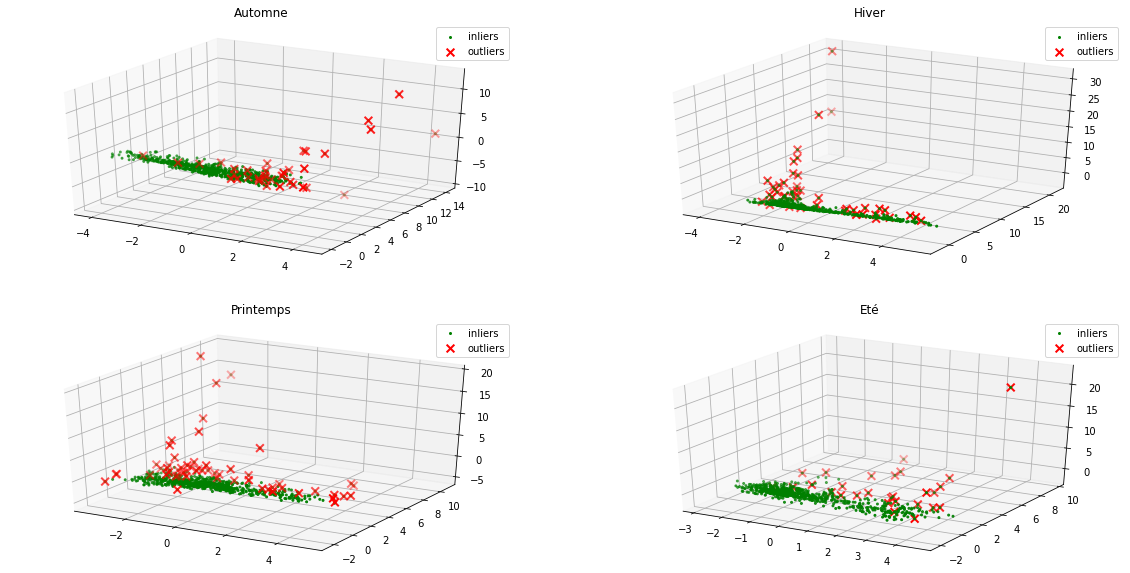

Errors verification: this data can be used for modeling. Based on DBSCAN algorithm result,
                 we have  5.664% of anomalies which is lower then 50.0% tolerated anoamlies
                  


(165, 2913)

In [250]:
ELHMA_seasonal_data = create_seasonal_data(elhma_data)
ELHMA_train_seasonal_data = split_data_into_train_and_test_sets(ELHMA_seasonal_data)
plot_and_test_errors_of_sesonal_anomalies(ELHMA_train_seasonal_data, ELHMA_seasonal_data, DB, percent_of_tolerated_errors, is_fit = False)

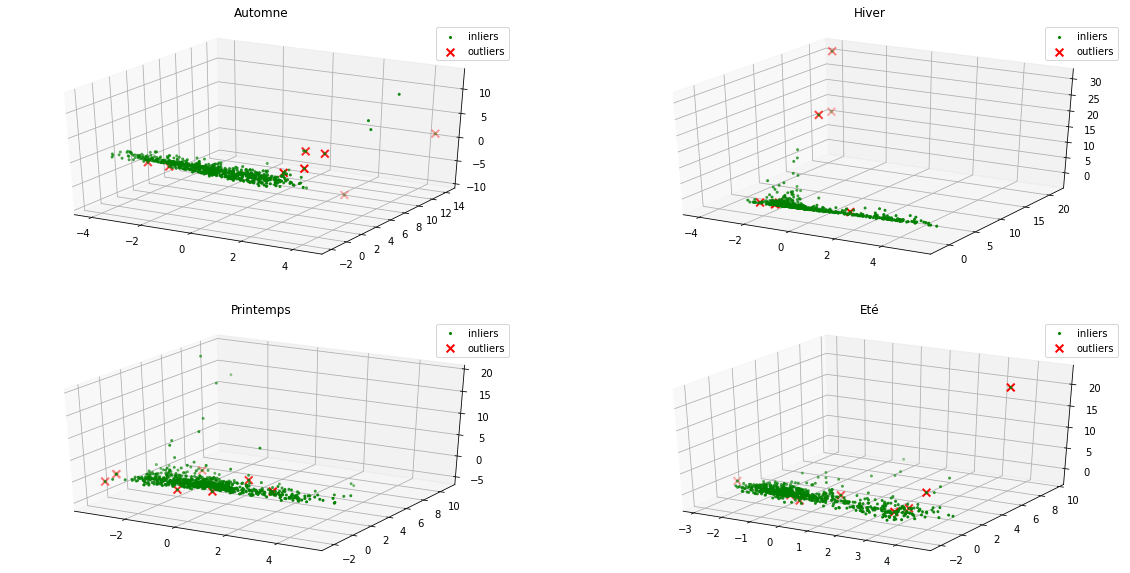

Errors verification: this data can be used for modeling. Based on LocalOutlierFactor algorithm result,
                 we have  1.099% of anomalies which is lower then 50.0% tolerated anoamlies
                  


(32, 2913)

In [251]:
ELHMA_seasonal_data = create_seasonal_data(elhma_data)
ELHMA_train_seasonal_data = split_data_into_train_and_test_sets(ELHMA_seasonal_data)
plot_and_test_errors_of_sesonal_anomalies(ELHMA_train_seasonal_data, ELHMA_seasonal_data, LOF, percent_of_tolerated_errors, is_fit = False)

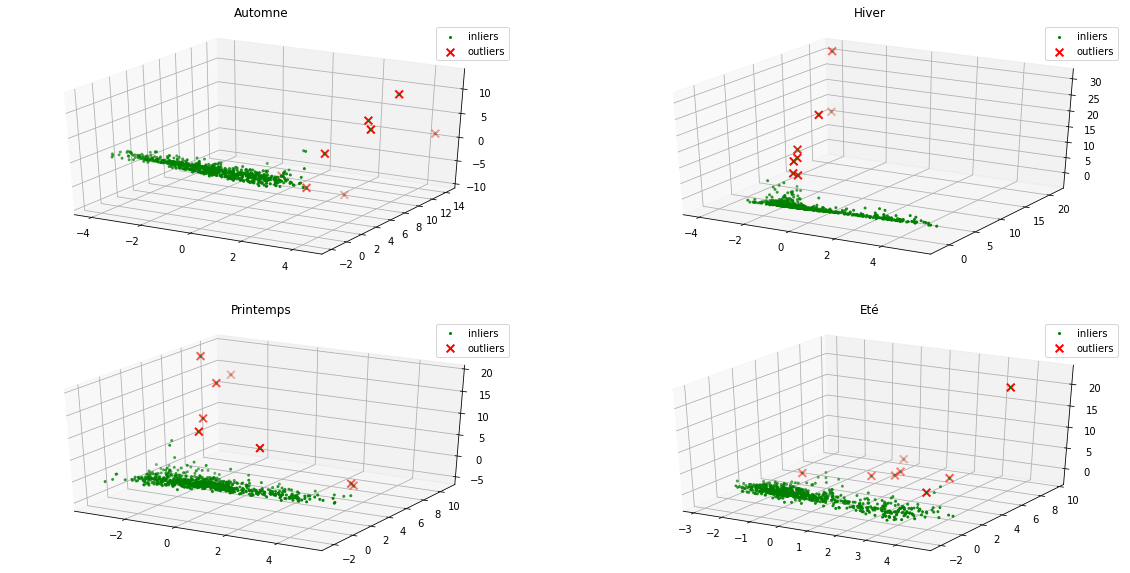

Errors verification: this data can be used for modeling. Based on IsolationForest algorithm result,
                 we have  1.099% of anomalies which is lower then 50.0% tolerated anoamlies
                  


(32, 2913)

In [252]:
ELHMA_seasonal_data = create_seasonal_data(elhma_data)
ELHMA_train_seasonal_data = split_data_into_train_and_test_sets(ELHMA_seasonal_data)
plot_and_test_errors_of_sesonal_anomalies(ELHMA_train_seasonal_data, ELHMA_seasonal_data, IForest, percent_of_tolerated_errors, is_fit = True)

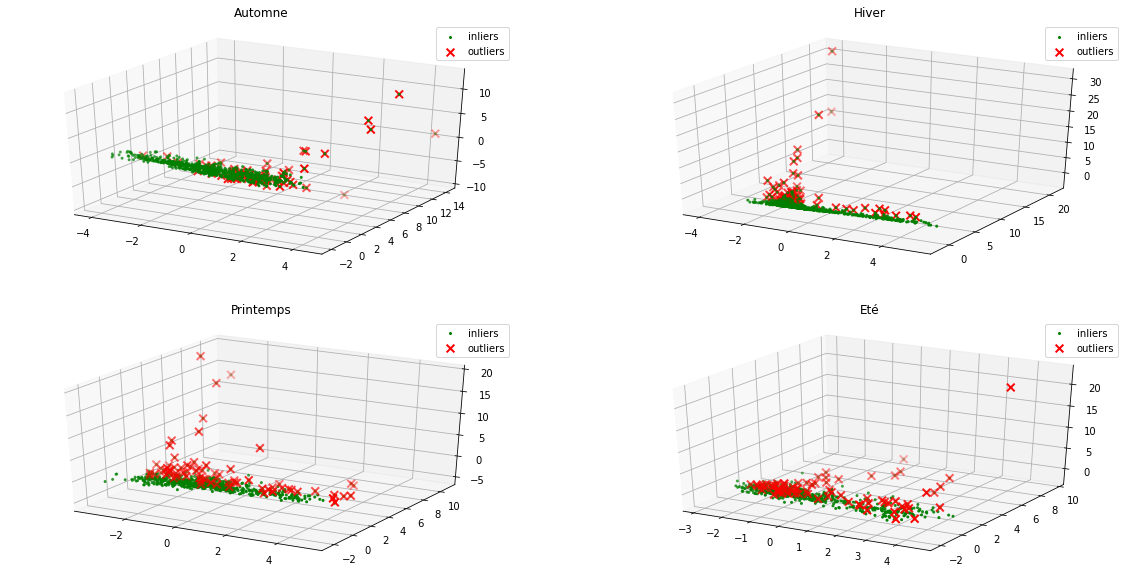

Errors verification: this data can be used for modeling. Based on EllipticEnvelope algorithm result,
                 we have  10.058% of anomalies which is lower then 50.0% tolerated anoamlies
                  


(293, 2913)

In [253]:
ELHMA_seasonal_data = create_seasonal_data(elhma_data)
ELHMA_train_seasonal_data = split_data_into_train_and_test_sets(ELHMA_seasonal_data)
plot_and_test_errors_of_sesonal_anomalies(ELHMA_train_seasonal_data, ELHMA_seasonal_data, EE, percent_of_tolerated_errors, is_fit = True)